### Data Import

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as mp
import os
from glob import glob
import seaborn as sns
from post_process import DataContainer
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter
import warnings
import pingouin as pg
from SRhelper import pfr, ros, conditional_ros, sps, fr_spc, murdock, lagCRP_curve, foelagCRP_curve, pos_outcomes_foeCRP, serposCRP, serposCRP_foe, FOE_stopping, rosdiff, find_perfectstart

import statsmodels as sm
from statsmodels.stats.anova import AnovaRM

sns.set(style='ticks', context="talk")
os.getcwd()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
OUTDATED_IGNORE = 1
%matplotlib inline

/home1/doughem/.conda/envs/AnalysisEnv/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home1/doughem/.conda/envs/AnalysisEnv/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home1/doughem/.conda/envs/AnalysisEnv/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### Read-In

In [2]:
paths_dict = {"experiment": 'serialrec_v2-4',
              'root': '/data/behavioral/mturk'}

container = DataContainer(**paths_dict)
start = container.get_cleaned_data()
notes_subs = start[start['listno'] >= 4]

In [3]:
len(notes_subs.subject.unique())

467

In [4]:
full_subs = pd.read_csv('./fullsubsE5.csv')
print(len(full_subs.subject.unique()))

589


In [5]:
#The data that comes in for this experiment encodes the "how" (aka fwd or bwd recall) and "when" (aka pre or post list pres)
#in the word events, but not in the recall events. This function assigns "how" and "when" values to the recall events (and 
#events that signify the start and end of recall) for purposes of later analysis. The second part of this function scores 
#correct recalls based on relative order scoring (correct if the recall prior was initially presented one prior in the case
#of fwd recall or one after in the case of backward). This function also creates a "repetition" column that is populated by
#0's and 1's for non-repeated and repeated items
def rec_assign(dataframe):
    warnings.filterwarnings('ignore') #ignore warnings that pandas gives me because it slows everything down
    dataframe['rel_recall'] = 0
    dataframe['repetition'] = 0
    assign_how = ''
    assign_when = ''
    rec_words = []
    for i in list(range(dataframe.shape[0])):
        if dataframe['type'].iloc[i] == 'START_RECALL':
            assign_how = dataframe['how'].iloc[i - 1] #grab the how value from the word event before the start of recall
            assign_when = dataframe['when'].iloc[i - 1] #grab the when value from the word event before the start of recall
            dataframe['how'].iloc[i] = assign_how
            dataframe['when'].iloc[i] = assign_when
            rec_words = []
            #note: because the 'REC_WORD' events below score the item one after their recall, first recalls must be accounted for here.
            if (dataframe['how'].iloc[i] == 'fwd') & (dataframe['serialpos'].iloc[i + 1] == 1.0):
                dataframe['rel_recall'].iloc[i + 1] = 1.0 #if serial pos of first recall in a fwd list == 1, correct
            elif (dataframe['how'].iloc[i] == 'bwd') & (dataframe['serialpos'].iloc[i + 1] == dataframe.list_length.iloc[i]):
                dataframe['rel_recall'].iloc[i + 1] = 1.0 #if serial pos of first recall in a fwd list == list length, correct
            continue 
        if dataframe['type'].iloc[i] == 'REC_WORD':
            dataframe['how'].iloc[i] = assign_how
            dataframe['when'].iloc[i] = assign_when
            if dataframe.intrusion.iloc[i] != 0:
                continue
            if dataframe['serialpos'].iloc[i] in rec_words:
                dataframe['repetition'].iloc[i] = 1
                continue
            rec_words.append(dataframe['serialpos'].iloc[i])
            if dataframe['serialpos'].iloc[i + 1] in rec_words:
                continue
            if dataframe['repetition'].iloc[i - 1] == 1:
                continue
            #here for relative recall, we score the following item, not the current. 
            if dataframe['how'].iloc[i] == 'fwd':
                if dataframe['serialpos'].iloc[i + 1] - dataframe['serialpos'].iloc[i] == 1.0:
                    #account for if the next item is the last recall event in the list
                    if (dataframe['type'].iloc[i + 2] == 'END_RECALL') & (dataframe['serialpos'].iloc[i + 1] == dataframe.list_length.iloc[i]):
                        dataframe['rel_recall'].iloc[i + 1] = 1.0
                        continue
                    dataframe['rel_recall'].iloc[i + 1] = 1.0
            if dataframe['how'].iloc[i] == 'bwd':
                if dataframe['serialpos'].iloc[i + 1] - dataframe['serialpos'].iloc[i] == -1.0:
                    #account for if the next item is the last recall event in the list
                    if (dataframe['type'].iloc[i + 2] == 'END_RECALL') & (dataframe['serialpos'].iloc[i + 1] == 1.0):
                        dataframe['rel_recall'].iloc[i + 1] = 1.0
                        continue
                    dataframe['rel_recall'].iloc[i + 1] = 1.0
        if dataframe['type'].iloc[i] == 'END_RECALL': 
            dataframe['how'].iloc[i] = assign_how
            dataframe['when'].iloc[i] = assign_when
            rec_words = []
    return dataframe

In [6]:
notes_subs = rec_assign(notes_subs)

In [7]:
notes_subs.to_csv('./fullsubsE5_wrotenotes.csv', index_label = 'index')

### Start Point

In [2]:
#Read-in of CSV if you want to avoid re-cleaning data.
subs = pd.read_csv('fullsubsE5.csv', index_col = 'index')
wrote_subs = pd.read_csv('fullsubsE5_wrotenotes.csv', index_col = 'index')

In [3]:
print(len(subs.subject.unique()))
print(len(wrote_subs.subject.unique()))

589
467


In [4]:
data_exclusions = subs.query('list_length > 12 | list_length < 6 ').subject.unique().tolist()
c2_incorrect = subs.query('list_length not in [6, 9, 12] and condition == 2.0').subject.unique().tolist()
c1_incorrect = subs.query('list_length not in [7, 9, 11] and condition == 1.0').subject.unique().tolist()
c0_incorrect = subs.query('list_length not in [8, 9, 10] and condition == 0.0').subject.unique().tolist()
sub_arrows = subs.query('item in ["→", "←"]').subject.unique().tolist()
sub_nans = subs.query('type == "REC_WORD" & item.isna() == True').subject.unique().tolist()
subs_exclude = set(sub_arrows + sub_nans)
data_exclusions = data_exclusions + c2_incorrect + c1_incorrect + c0_incorrect
subs = subs.query('subject not in @data_exclusions & subject not in @subs_exclude')
print(len(subs.subject.unique()))

552


In [5]:
data_exclusions = wrote_subs.query('list_length > 12 | list_length < 6 ').subject.unique().tolist()
c2_incorrect = wrote_subs.query('list_length not in [6, 9, 12] and condition == 2.0').subject.unique().tolist()
c1_incorrect = wrote_subs.query('list_length not in [7, 9, 11] and condition == 1.0').subject.unique().tolist()
c0_incorrect = wrote_subs.query('list_length not in [8, 9, 10] and condition == 0.0').subject.unique().tolist()
sub_arrows = wrote_subs.query('item in ["→", "←"]').subject.unique().tolist()
sub_nans = wrote_subs.query('type == "REC_WORD" & item.isna() == True').subject.unique().tolist()
wrote_subs_exclude = set(sub_arrows + sub_nans)
data_exclusions = data_exclusions + c2_incorrect + c1_incorrect + c0_incorrect
wrote_subs = wrote_subs.query('subject not in @data_exclusions & subject not in @wrote_subs_exclude')
print(len(wrote_subs.subject.unique()))

435


### Rec Rate

In [6]:
subs_solway = subs[subs['type'] == 'REC_WORD'].groupby('subject').agg({'rel_recall':'sum'}).reset_index().merge(subs[subs['type'] == 'WORD'].groupby('subject').agg({'type':'count'}).reset_index(), on = 'subject')
noanswer_solway = empty_subs[empty_subs['type'] == 'REC_WORD'].groupby('subject').agg({'rel_recall':'sum'}).reset_index().merge(empty_subs[empty_subs['type'] == 'WORD'].groupby('subject').agg({'type':'count'}).reset_index(), on = 'subject')
wrote_solway = notes_subs[notes_subs['type'] == 'REC_WORD'].groupby('subject').agg({'rel_recall':'sum'}).reset_index().merge(notes_subs[notes_subs['type'] == 'WORD'].groupby('subject').agg({'type':'count'}).reset_index(), on = 'subject')

NameError: name 'empty_subs' is not defined

In [ ]:
subs_solway['rec_rate'] = subs_solway.rel_recall/subs_solway.type
noanswer_solway['rec_rate'] = noanswer_solway.rel_recall/noanswer_solway.type
wrote_solway['rec_rate'] = wrote_solway.rel_recall/wrote_solway.type
print(subs_solway['rec_rate'].mean())
print(noanswer_solway['rec_rate'].mean())
print(wrote_solway['rec_rate'].mean())

In [30]:
stats.ttest_ind(subs_solway['rec_rate'], noanswer_solway['rec_rate'], equal_var = False)

Ttest_indResult(statistic=-4.00731327524256, pvalue=7.18974392234242e-05)

In [8]:
subs9 = subs.query('list_length == 9')
bwdlist = list(range(1, 10))
bwdlist.reverse() #create a list ordered from list_length to 1
store = -1 #create an integer variable that will later store the index position of the start of each recall list 
subs9['expected_outputpos'] = -999
#populate the expected output position column
for i in list(range(subs9.shape[0])):
    if subs9.type.iloc[i] == 'REC_WORD':
        if subs9.how.iloc[i] == 'fwd':
            subs9.expected_outputpos.iloc[i] = subs9.serialpos.iloc[i] #if fwd, expect fwd sequential recall
        if (subs9.how.iloc[i] == 'bwd') & (subs9.outpos.iloc[i] in bwdlist):
            subs9.expected_outputpos.iloc[i] = bwdlist[int(subs9.serialpos.iloc[i] - 1)] #if bwd, expect it bwd sequential recall

<ipython-input-8-2ededce6a965>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subs9['expected_outputpos'] = -999
/home1/doughem/.conda/envs/AnalysisEnv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home1/doughem/.conda/envs/AnalysisEnv/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [9]:
wrote_subs9 = wrote_subs.query('list_length == 9')
bwdlist = list(range(1, 10))
bwdlist.reverse() #create a list ordered from list_length to 1
store = -1 #create an integer variable that will later store the index position of the start of each recall list
wrote_subs9['expected_outputpos'] = -999
#populate the expected output position column
for i in list(range(wrote_subs9.shape[0])):
    if wrote_subs9.type.iloc[i] == 'REC_WORD':
        if wrote_subs9.how.iloc[i] == 'fwd':
            wrote_subs9.expected_outputpos.iloc[i] = wrote_subs9.serialpos.iloc[i] #if fwd, expect fwd sequential recall
    if (wrote_subs9.how.iloc[i] == 'bwd') & (wrote_subs9.outpos.iloc[i] in bwdlist) & (math.isnan(wrote_subs9.serialpos.iloc[i]) == False):
        wrote_subs9.expected_outputpos.iloc[i] = bwdlist[int(wrote_subs9.serialpos.iloc[i] - 1)] #if bwd, expect it bwd sequential recall

<ipython-input-9-136f81bfab0e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrote_subs9['expected_outputpos'] = -999
/home1/doughem/.conda/envs/AnalysisEnv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home1/doughem/.conda/envs/AnalysisEnv/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

In [10]:
# Solway 9
rec_subs = subs9.query('rel_recall == 1')
word_subs = subs9.query('type == "WORD"')
solway_rate_df = pd.DataFrame(columns = ['subject', 'fwd_rec_rate', 'bwd_rec_rate'])
for sub in subs9.subject.unique():
    rec_sub_df = rec_subs.query('subject == @sub')
    word_sub_df = word_subs.query('subject == @sub')
    helper_list = []
    helper_list.append(sub)
    helper_list.append(rec_sub_df.query('how == "fwd"').shape[0]/word_sub_df.query('how == "fwd"').shape[0])
    helper_list.append(rec_sub_df.query('how == "bwd"').shape[0]/word_sub_df.query('how == "bwd"').shape[0])
    solway_rate_df = solway_rate_df.append(pd.Series(helper_list, index = ['subject', 'fwd_rec_rate', 'bwd_rec_rate']),
                                     ignore_index = True)

In [11]:
rec_wrote_subs = wrote_subs9.query('rel_recall == 1')
word_wrote_subs = wrote_subs9.query('type == "WORD"')
solway_wrote_rate_df = pd.DataFrame(columns = ['subject', 'fwd_rec_rate', 'bwd_rec_rate'])
for sub in wrote_subs9.subject.unique():
    rec_sub_df = rec_wrote_subs.query('subject == @sub')
    word_sub_df = word_wrote_subs.query('subject == @sub')
    helper_list = []
    helper_list.append(sub)
    helper_list.append(rec_sub_df.query('how == "fwd"').shape[0]/word_sub_df.query('how == "fwd"').shape[0])
    helper_list.append(rec_sub_df.query('how == "bwd"').shape[0]/word_sub_df.query('how == "bwd"').shape[0])
    solway_wrote_rate_df = solway_wrote_rate_df.append(pd.Series(helper_list, index = ['subject', 'fwd_rec_rate', 'bwd_rec_rate']), ignore_index = True)

In [41]:
# SPS
rec_subs = subs9.query('type == "REC_WORD" & outpos == expected_outputpos')
word_subs = subs9.query('type == "WORD"')
sps_rate_df = pd.DataFrame(columns = ['subject', 'fwd_rec_rate', 'bwd_rec_rate'])
for sub in subs9.subject.unique():
    rec_sub_df = rec_subs.query('subject == @sub')
    word_sub_df = word_subs.query('subject == @sub')
    helper_list = []
    helper_list.append(sub)
    helper_list.append(rec_sub_df.query('how == "fwd"').shape[0]/word_sub_df.query('how == "fwd"').shape[0])
    helper_list.append(rec_sub_df.query('how == "bwd"').shape[0]/word_sub_df.query('how == "bwd"').shape[0])
    sps_rate_df = sps_rate_df.append(pd.Series(helper_list, index = ['subject', 'fwd_rec_rate', 'bwd_rec_rate']),
                                     ignore_index = True)

In [42]:
# sps_wrote
rec_wrote_subs = wrote_subs9.query('type == "REC_WORD" & outpos == expected_outputpos')
word_wrote_subs = wrote_subs9.query('type == "WORD"')
sps_wrote_rate_df = pd.DataFrame(columns = ['subject', 'fwd_rec_rate', 'bwd_rec_rate'])
for sub in wrote_subs9.subject.unique():
    rec_sub_df = rec_wrote_subs.query('subject == @sub')
    word_sub_df = word_wrote_subs.query('subject == @sub')
    helper_list = []
    helper_list.append(sub)
    helper_list.append(rec_sub_df.query('how == "fwd"').shape[0]/word_sub_df.query('how == "fwd"').shape[0])
    helper_list.append(rec_sub_df.query('how == "bwd"').shape[0]/word_sub_df.query('how == "bwd"').shape[0])
    sps_wrote_rate_df = sps_wrote_rate_df.append(pd.Series(helper_list, index = ['subject', 'fwd_rec_rate', 'bwd_rec_rate']),
                                     ignore_index = True)

In [43]:
sps9p = stats.ttest_rel(sps_rate_df.fwd_rec_rate, sps_rate_df.bwd_rec_rate)[1]

In [44]:
# FR
rec_subs = subs9.query('type == "REC_WORD" & repetition != 1.0 & intrusion == 0.0')
word_subs = subs9.query('type == "WORD"')
fr_rate_df = pd.DataFrame(columns = ['subject', 'fwd_rec_rate', 'bwd_rec_rate'])
for sub in subs9.subject.unique():
    rec_sub_df = rec_subs.query('subject == @sub')
    word_sub_df = word_subs.query('subject == @sub')
    helper_list = []
    helper_list.append(sub)
    helper_list.append(rec_sub_df.query('how == "fwd"').shape[0]/word_sub_df.query('how == "fwd"').shape[0])
    helper_list.append(rec_sub_df.query('how == "bwd"').shape[0]/word_sub_df.query('how == "bwd"').shape[0])
    fr_rate_df = fr_rate_df.append(pd.Series(helper_list, index = ['subject', 'fwd_rec_rate', 'bwd_rec_rate']),
                                     ignore_index = True)

In [45]:
# FR
rec_wrote_subs = wrote_subs9.query('type == "REC_WORD" & repetition != 1.0 & intrusion == 0.0')
word_wrote_subs = wrote_subs9.query('type == "WORD"')
fr_wrote_rate_df = pd.DataFrame(columns = ['subject', 'fwd_rec_rate', 'bwd_rec_rate'])
for sub in wrote_subs9.subject.unique():
    rec_sub_df = rec_wrote_subs.query('subject == @sub')
    word_sub_df = word_wrote_subs.query('subject == @sub')
    helper_list = []
    helper_list.append(sub)
    helper_list.append(rec_sub_df.query('how == "fwd"').shape[0]/word_sub_df.query('how == "fwd"').shape[0])
    helper_list.append(rec_sub_df.query('how == "bwd"').shape[0]/word_sub_df.query('how == "bwd"').shape[0])
    fr_wrote_rate_df = fr_wrote_rate_df.append(pd.Series(helper_list, index = ['subject', 'fwd_rec_rate', 'bwd_rec_rate']),
                                     ignore_index = True)

In [46]:
fr9p = stats.ttest_rel(fr_rate_df.fwd_rec_rate, fr_rate_df.bwd_rec_rate)[1]

In [47]:
# Murdock: 
murdfwd = murdock(subs, 9, how = 'fwd')
murdbwd = murdock(subs, 9, how = 'bwd', flip_bwd = True)
murdfwd1 = murdfwd[['subject', 'actual_count', 'possible_count', 'how']].groupby('subject').agg({'actual_count': 'sum', 'possible_count':'sum'})
murdbwd1 = murdbwd[['subject', 'actual_count', 'possible_count', 'how']].groupby('subject').agg({'actual_count': 'sum', 'possible_count':'sum'})

In [48]:
# murd_wroteock:
murd_wrotefwd = murdock(wrote_subs, 9, how = 'fwd')
murd_wrotebwd = murdock(wrote_subs, 9, how = 'bwd', flip_bwd = True)
murd_wrotefwd1 = murd_wrotefwd[['subject', 'actual_count', 'possible_count', 'how']].groupby('subject').agg({'actual_count': 'sum', 'possible_count':'sum'})
murd_wrotebwd1 = murd_wrotebwd[['subject', 'actual_count', 'possible_count', 'how']].groupby('subject').agg({'actual_count': 'sum', 'possible_count':'sum'})

In [49]:
murd9p = stats.ttest_rel(murdfwd1.actual_count/murdfwd1.possible_count, murdbwd1.actual_count/murdbwd1.possible_count)[1]

In [50]:
# COS: 
cosfwd = conditional_ros(subs, 9, how = 'fwd')
cosbwd = conditional_ros(subs, 9, how = 'bwd', flip_bwd = True)

In [51]:
cosfwd1 = cosfwd[['subject', 'actual_count', 'possible_count', 'how']].groupby('subject').agg({'actual_count': 'sum', 'possible_count':'sum'})
cosbwd1 = cosbwd[['subject', 'actual_count', 'possible_count', 'how']].groupby('subject').agg({'actual_count': 'sum', 'possible_count':'sum'})

In [52]:
cosfwd_wrote = conditional_ros(wrote_subs, 9, how = 'fwd')
cosbwd_wrote = conditional_ros(wrote_subs, 9, how = 'bwd', flip_bwd = True)

In [53]:
cosfwd_wrote1 = cosfwd_wrote[['subject', 'actual_count', 'possible_count', 'how']].groupby('subject').agg({'actual_count': 'sum', 'possible_count':'sum'})
cosbwd_wrote1 = cosbwd_wrote[['subject', 'actual_count', 'possible_count', 'how']].groupby('subject').agg({'actual_count': 'sum', 'possible_count':'sum'})

In [54]:
cos9p = stats.ttest_rel(cosfwd1.actual_count/cosfwd1.possible_count, cosbwd1.actual_count/cosbwd1.possible_count)[1]

In [55]:
pvals = [sol9p, murd9p, fr9p, cos9p, sps9p]
sm.stats.multitest.fdrcorrection(pvals, alpha = 0.05)

NameError: name 'sol9p' is not defined

In [56]:
fwd_scores = [solway_rate_df.fwd_rec_rate.mean(), solway_wrote_rate_df.fwd_rec_rate.mean(), (murdfwd1.actual_count/murdfwd1.possible_count).mean(), 
              (murd_wrotefwd1.actual_count/murd_wrotefwd1.possible_count).mean(), fr_rate_df.fwd_rec_rate.mean(), fr_wrote_rate_df.fwd_rec_rate.mean(), 
              (cosfwd1.actual_count/cosfwd1.possible_count).mean(), (cosfwd_wrote1.actual_count/cosfwd_wrote1.possible_count).mean(),
              sps_rate_df.fwd_rec_rate.mean(), sps_wrote_rate_df.fwd_rec_rate.mean()]

In [57]:
bwd_scores = [solway_rate_df.bwd_rec_rate.mean(), solway_wrote_rate_df.bwd_rec_rate.mean(), (murdbwd1.actual_count/murdbwd1.possible_count).mean(),
              (murd_wrotebwd1.actual_count/murd_wrotebwd1.possible_count).mean(), fr_rate_df.bwd_rec_rate.mean(), fr_wrote_rate_df.bwd_rec_rate.mean(),
              (cosbwd1.actual_count/cosbwd1.possible_count).mean(), (cosbwd_wrote1.actual_count/cosbwd_wrote1.possible_count).mean(),
              sps_rate_df.bwd_rec_rate.mean(), sps_wrote_rate_df.bwd_rec_rate.mean()]

In [12]:
fwd_scores = [solway_rate_df.fwd_rec_rate.mean(), solway_wrote_rate_df.fwd_rec_rate.mean()]
bwd_scores = [solway_rate_df.bwd_rec_rate.mean(), solway_wrote_rate_df.bwd_rec_rate.mean()]

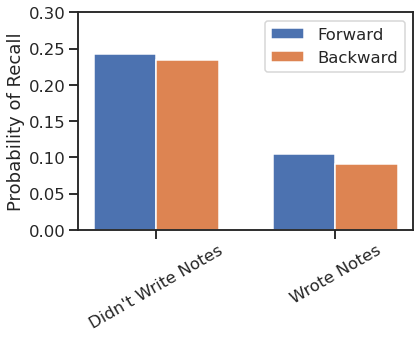

In [16]:
fig, ax = plt.subplots(figsize = (6,4))

labels = ["Didn't Write Notes", 'Wrote Notes']

x = np.arange(len(labels))
width = 0.35  # the width of the bars

fwd = ax.bar(x - width/2, fwd_scores, width, label='Forward')
bwd = ax.bar(x + width/2, bwd_scores, width, label='Backward')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Probability of Recall')
ax.set_xticks(x)
ax.set_ylim([0, 0.3])
ax.set_xticklabels(labels)
plt.xticks(rotation = 30)
ax.legend()
fig.savefig("./../graphsE5/RecRate_Notes.pdf", bbox_inches = 'tight',pad_inches = 0.2)

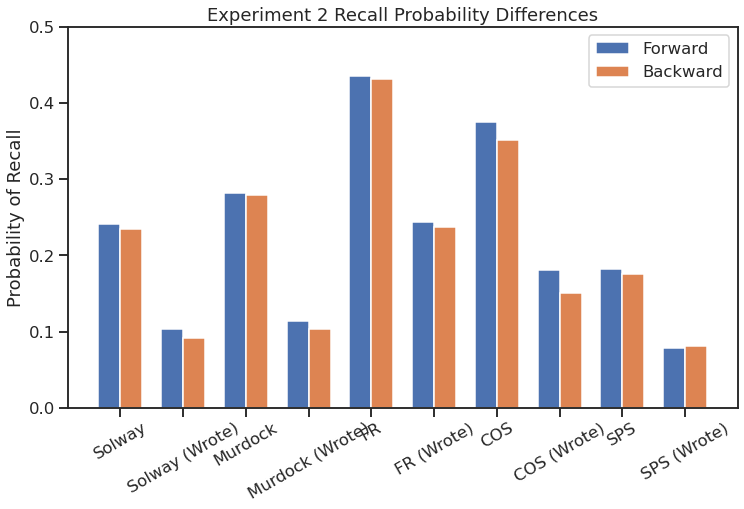

In [59]:
fig, ax = plt.subplots(figsize = (12,7))

labels = ['Solway', 'Solway (Wrote)', 'Murdock', 'Murdock (Wrote)', 'FR', 'FR (Wrote)',
          'COS', 'COS (Wrote)', 'SPS', 'SPS (Wrote)']

x = np.arange(len(labels))
width = 0.35  # the width of the bars

fwd = ax.bar(x - width/2, fwd_scores, width, label='Forward')
bwd = ax.bar(x + width/2, bwd_scores, width, label='Backward')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Probability of Recall')
ax.set_xticks(x)
ax.set_ylim([0, 0.5])
ax.set_xticklabels(labels)
plt.xticks(rotation = 30)
ax.set_title('Experiment 2 Recall Probability Differences')
ax.legend()
# fig.savefig("./../graphs/FinalSPC/Compare_Methods.pdf", bbox_inches = 'tight',pad_inches = 0.2)

### SPC

In [ ]:
solwayfwd = ros(subs, 9, how = 'fwd')
solwaybwd = ros(subs, 9, how = 'bwd', flip_bwd = True)
solwayfwd_WN = ros(wrote_subs, 9, how = 'fwd')
solwaybwd_WN = ros(wrote_subs, 9, how = 'bwd', flip_bwd = True)

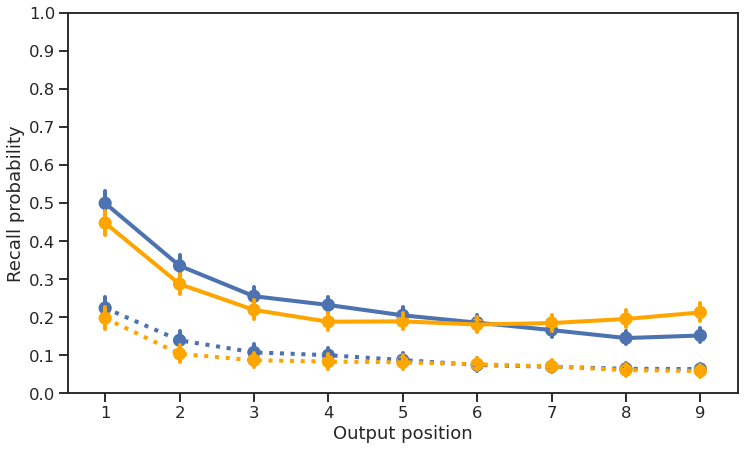

In [8]:
solwayfig = plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=solwayfwd, x='x_values', y='probability', marker = 'o')
ax2 = sns.pointplot(data=solwaybwd, x='x_values', y='probability', marker = 'o', color = 'orange')
ax5 = sns.pointplot(data=solwayfwd_WN, x='x_values', y='probability', marker = 'o', linestyles = ':')
ax6 = sns.pointplot(data=solwaybwd_WN, x='x_values', y='probability', marker = 'o', color = 'orange', linestyles = ':')
plt.xlabel('Output position')
plt.ylabel('Recall probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
solwayfig.savefig("./../graphsE5/Notes_SPC2.pdf", bbox_inches = 'tight',pad_inches = 0.2)

In [9]:
pfrfwd9 = pfr(subs, 9, how = 'fwd')
pfrbwd9flip = pfr(subs, 9, how = 'bwd', flip_bwd = True)
pfrfwd9_WN = pfr(wrote_subs, 9, how = 'fwd')
pfrbwd9flip_WN = pfr(wrote_subs, 9, how = 'bwd', flip_bwd = True)

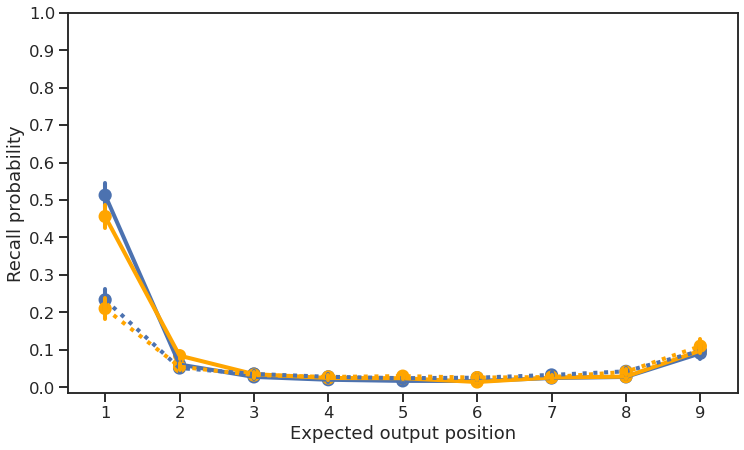

In [10]:
pfr_op = plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=pfrfwd9, x='x_values', y='probability', marker = 'o')
ax2 = sns.pointplot(data=pfrbwd9flip, x='x_values', y='probability', marker = 'o', color = 'orange')
ax5 = sns.pointplot(data=pfrfwd9_WN, x='x_values', y='probability', marker = 'o', linestyles = ':')
ax6 = sns.pointplot(data=pfrbwd9flip_WN, x='x_values', y='probability', marker = 'o', color = 'orange', linestyles = ':')
plt.xlabel('Expected output position')
plt.ylabel('Recall probability')
ax5.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
pfr_op.savefig("./../graphsE5/Notes_PFR2.pdf", bbox_inches = 'tight',pad_inches = 0.2)

### CRPs

In [11]:
crp9fwd = lagCRP_curve(subs, 9, how = 'fwd')
crp9bwd = lagCRP_curve(subs, 9, how = 'bwd')
crp9fwd_WN = lagCRP_curve(wrote_subs, 9, how = 'fwd')
crp9bwd_WN = lagCRP_curve(wrote_subs, 9, how = 'bwd')

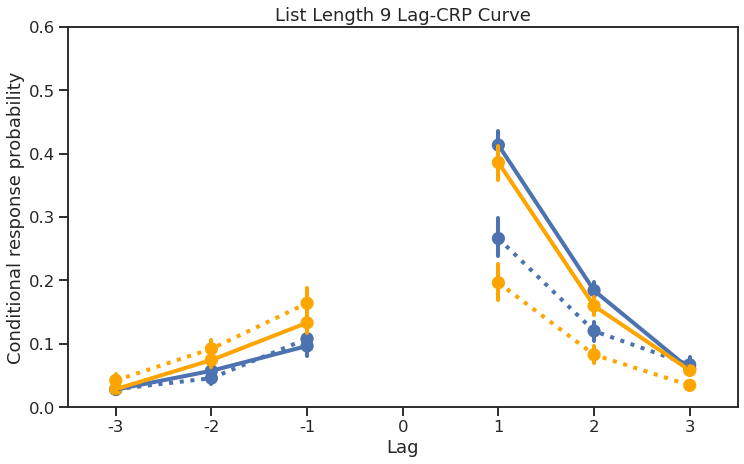

In [12]:
crp9fig= plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=crp9fwd, x='x_values', y='probability')
ax2 = sns.pointplot(data=crp9fwd_WN, x='x_values', y='probability', linestyles = ':')
ax3 = sns.pointplot(data=crp9bwd_WN, x='x_values', y='probability', color = 'orange', linestyles = ':')
ax4 = sns.pointplot(data=crp9bwd, x='x_values', y='probability',  color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
plt.title('List Length 9 Lag-CRP Curve')
crp9fig.savefig("./../graphsE5/Notes_CRP2.pdf", bbox_inches = 'tight',pad_inches = 0.2)

### CRP Archive

In [13]:
foejump1crp9fwd = foelagCRP_curve(subs, 9, how = 'fwd', jump = 2)
foejump1crp9bwd = foelagCRP_curve(subs, 9, how = 'bwd', jump = 2)
foejump1crp9fwd_NA = foelagCRP_curve(full_subs, 9, how = 'fwd', jump = 2)
foejump1crp9bwd_NA = foelagCRP_curve(full_subs, 9, how = 'bwd', jump = 2)
foejump1crp9fwd = foejump1crp9fwd[(foejump1crp9fwd.x_values != -3) & (foejump1crp9fwd.x_values != -2)]
foejump1crp9bwd = foejump1crp9bwd[(foejump1crp9bwd.x_values != -3) & (foejump1crp9bwd.x_values != -2)]
foejump1crp9fwd_NA = foejump1crp9fwd_NA[(foejump1crp9fwd_NA.x_values != -3) & (foejump1crp9fwd_NA.x_values != -2)]
foejump1crp9bwd_NA = foejump1crp9bwd_NA[(foejump1crp9bwd_NA.x_values != -3) & (foejump1crp9bwd_NA.x_values != -2)]


NameError: name 'full_subs' is not defined

In [ ]:
foejump1crp9fwdcuefig= plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=foejump1crp9fwd, x='x_values', y='probability', marker = 'o')
ax2 = sns.pointplot(data=foejump1crp9fwd_NA, x='x_values', y='probability', markers = 'x', linestyles = '--')
ax3 = sns.pointplot(data=foejump1crp9bwd, x='x_values', y='probability', marker = 'o', color = 'orange')
ax4 = sns.pointplot(data=foejump1crp9bwd_NA, x='x_values', y='probability', markers = 'x', linestyles = '--', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

In [ ]:
crp9fwd_pos1 = lagCRP_curve(full_subs, 9, how = 'fwd').query('x_values == 1')
crp9bwd_pos1 = lagCRP_curve(full_subs, 9, how = 'bwd').query('x_values == 1')

crp9fwd_pos1.dropna(inplace = True)
crp9bwd_pos1.dropna(inplace = True)

crp9fwd_pos1 = crp9fwd_pos1.query('subject in @crp9bwd_pos1.subject.unique()')
crp9bwd_pos1 = crp9bwd_pos1.query('subject in @crp9fwd_pos1.subject.unique()')

stats.ttest_rel(crp9fwd_pos1.probability, crp9bwd_pos1.probability)

In [ ]:
crp9fwd_neg1 = lagCRP_curve(full_subs, 9, how = 'fwd').query('x_values == -1')
crp9bwd_neg1 = lagCRP_curve(full_subs, 9, how = 'bwd').query('x_values == -1')

crp9fwd_neg1.dropna(inplace = True)
crp9bwd_neg1.dropna(inplace = True)

crp9fwd_neg1 = crp9fwd_neg1.query('subject in @crp9bwd_neg1.subject.unique()')
crp9bwd_neg1 = crp9bwd_neg1.query('subject in @crp9fwd_neg1.subject.unique()')

stats.ttest_rel(crp9fwd_neg1.probability, crp9bwd_neg1.probability)

In [64]:
foecrp9fwd_neg1 = foelagCRP_curve(full_subs, 9, how = 'fwd', jump = 2).query('x_values == -1')
foecrp9bwd_neg1 = foelagCRP_curve(full_subs, 9, how = 'bwd', jump = 2).query('x_values == -1')

foecrp9fwd_neg1.dropna(inplace = True)
foecrp9bwd_neg1.dropna(inplace = True)

foecrp9fwd_neg1 = foecrp9fwd_neg1.query('subject in @foecrp9bwd_neg1.subject.unique()')
foecrp9bwd_neg1 = foecrp9bwd_neg1.query('subject in @foecrp9fwd_neg1.subject.unique()')

stats.ttest_rel(foecrp9fwd_neg1.probability, foecrp9bwd_neg1.probability)

Ttest_relResult(statistic=-2.9977525526647777, pvalue=0.002913032866111747)

In [65]:
foecrp9fwd_over1 = pos_outcomes_foeCRP(full_subs, 9, how = 'fwd', jump = 2).query('x_values == 1')
foecrp9bwd_over1 = pos_outcomes_foeCRP(full_subs, 9, how = 'bwd', jump = 2).query('x_values == 1')

foecrp9fwd_over1.dropna(inplace = True)
foecrp9bwd_over1.dropna(inplace = True)

foecrp9fwd_over1 = foecrp9fwd_over1.query('subject in @foecrp9bwd_over1.subject.unique()')
foecrp9bwd_over1 = foecrp9bwd_over1.query('subject in @foecrp9fwd_over1.subject.unique()')

stats.ttest_rel(foecrp9fwd_over1.probability, foecrp9bwd_over1.probability)

Ttest_relResult(statistic=3.2550748672849448, pvalue=0.0012445883305039996)

In [66]:
foecrp9fwd_pos1 = foelagCRP_curve(full_subs, 9, how = 'fwd', jump = 2).query('x_values == 1')
foecrp9bwd_pos1 = foelagCRP_curve(full_subs, 9, how = 'bwd', jump = 2).query('x_values == 1')

foecrp9fwd_pos1.dropna(inplace = True)
foecrp9bwd_pos1.dropna(inplace = True)

foecrp9fwd_pos1 = foecrp9fwd_pos1.query('subject in @foecrp9bwd_pos1.subject.unique()')
foecrp9bwd_pos1 = foecrp9bwd_pos1.query('subject in @foecrp9fwd_pos1.subject.unique()')

stats.ttest_rel(foecrp9fwd_pos1.probability, foecrp9bwd_pos1.probability)

Ttest_relResult(statistic=1.085130695046951, pvalue=0.27861276664523543)

In [67]:
foecrp9fwd_over1_inc = pos_outcomes_foeCRP(full_subs, 9, how = 'fwd', jump = 2, exclude_correct = True).query('x_values == 1')
foecrp9bwd_over1_inc = pos_outcomes_foeCRP(full_subs, 9, how = 'bwd', jump = 2, exclude_correct = True).query('x_values == 1')

foecrp9fwd_over1_inc.dropna(inplace = True)
foecrp9bwd_over1_inc.dropna(inplace = True)

foecrp9fwd_over1_inc = foecrp9fwd_over1_inc.query('subject in @foecrp9bwd_over1_inc.subject.unique()')
foecrp9bwd_over1_inc = foecrp9bwd_over1_inc.query('subject in @foecrp9fwd_over1_inc.subject.unique()')

stats.ttest_rel(foecrp9fwd_over1_inc.probability, foecrp9bwd_over1_inc.probability)

Ttest_relResult(statistic=2.5040703844611176, pvalue=0.012742478431359177)

In [68]:
crp9fwdpre_neg1 = crp9fwdpre.query('x_values == -1')
crp9bwdpre_neg1 = crp9bwdpre.query('x_values == -1')
crp9fwdpost_neg1 = crp9fwdpost.query('x_values == -1')
crp9bwdpost_neg1 = crp9bwdpost.query('x_values == -1')

In [69]:
crp9fwdpre_neg1.dropna(inplace = True)
crp9bwdpre_neg1.dropna(inplace = True)
crp9fwdpost_neg1.dropna(inplace = True)
crp9bwdpost_neg1.dropna(inplace = True)

crp9fwdpre_neg1 = crp9fwdpre_neg1.query('subject in @crp9fwdpost_neg1.subject.values')
crp9fwdpost_neg1 = crp9fwdpost_neg1.query('subject in @crp9fwdpre_neg1.subject.values')

crp9bwdpre_neg1 = crp9bwdpre_neg1.query('subject in @crp9bwdpost_neg1.subject.values')
crp9bwdpost_neg1 = crp9bwdpost_neg1.query('subject in @crp9bwdpre_neg1.subject.values')

crp9fwdpre_neg1 = crp9fwdpre_neg1.query('subject in @crp9bwdpre_neg1.subject.values')
crp9bwdpre_neg1 = crp9bwdpre_neg1.query('subject in @crp9fwdpre_neg1.subject.values')

crp9fwdpre_neg1 = crp9fwdpre_neg1.query('subject in @crp9fwdpost_neg1.subject.values')
crp9fwdpost_neg1 = crp9fwdpost_neg1.query('subject in @crp9fwdpre_neg1.subject.values')

crp9bwdpre_neg1 = crp9bwdpre_neg1.query('subject in @crp9bwdpost_neg1.subject.values')
crp9bwdpost_neg1 = crp9bwdpost_neg1.query('subject in @crp9bwdpre_neg1.subject.values')

onelagcrp9cue = pd.concat([crp9fwdpre_neg1, crp9bwdpre_neg1, crp9fwdpost_neg1, crp9bwdpost_neg1])
onelagcrp9cue.sort_values('subject', inplace = True)
onelagcrp9cue.to_csv('./../graphs/NoResponse9/Stat_CSVs/Lag_NegOne_Cue')

In [70]:
crp9fwdpre_pos1 = crp9fwdpre.query('x_values == 1')
crp9bwdpre_pos1 = crp9bwdpre.query('x_values == 1')
crp9fwdpost_pos1 = crp9fwdpost.query('x_values == 1')
crp9bwdpost_pos1 = crp9bwdpost.query('x_values == 1')

In [71]:
crp9fwdpre_pos1.dropna(inplace = True)
crp9bwdpre_pos1.dropna(inplace = True)
crp9fwdpost_pos1.dropna(inplace = True)
crp9bwdpost_pos1.dropna(inplace = True)

crp9fwdpre_pos1 = crp9fwdpre_pos1.query('subject in @crp9fwdpost_pos1.subject.values')
crp9fwdpost_pos1 = crp9fwdpost_pos1.query('subject in @crp9fwdpre_pos1.subject.values')

crp9bwdpre_pos1 = crp9bwdpre_pos1.query('subject in @crp9bwdpost_pos1.subject.values')
crp9bwdpost_pos1 = crp9bwdpost_pos1.query('subject in @crp9bwdpre_pos1.subject.values')

crp9fwdpre_pos1 = crp9fwdpre_pos1.query('subject in @crp9bwdpre_pos1.subject.values')
crp9bwdpre_pos1 = crp9bwdpre_pos1.query('subject in @crp9fwdpre_pos1.subject.values')

crp9fwdpre_pos1 = crp9fwdpre_pos1.query('subject in @crp9fwdpost_pos1.subject.values')
crp9fwdpost_pos1 = crp9fwdpost_pos1.query('subject in @crp9fwdpre_pos1.subject.values')

crp9bwdpre_pos1 = crp9bwdpre_pos1.query('subject in @crp9bwdpost_pos1.subject.values')
crp9bwdpost_pos1 = crp9bwdpost_pos1.query('subject in @crp9bwdpre_pos1.subject.values')

onelagcrp9cue = pd.concat([crp9fwdpre_pos1, crp9bwdpre_pos1, crp9fwdpost_pos1, crp9bwdpost_pos1])
onelagcrp9cue.sort_values('subject', inplace = True)
onelagcrp9cue.to_csv('./../graphs/NoResponse9/Stat_CSVs/Lag_PosOne_Cue')

In [72]:
foecrp9fwdpre_neg1 = foejump1crp9fwdpre.query('x_values == -1')
foecrp9bwdpre_neg1 = foejump1crp9bwdpre.query('x_values == -1')
foecrp9fwdpost_neg1 = foejump1crp9fwdpost.query('x_values == -1')
foecrp9bwdpost_neg1 = foejump1crp9bwdpost.query('x_values == -1')

In [73]:
foecrp9fwdpre_neg1.dropna(inplace = True)
foecrp9bwdpre_neg1.dropna(inplace = True)
foecrp9fwdpost_neg1.dropna(inplace = True)
foecrp9bwdpost_neg1.dropna(inplace = True)

foecrp9fwdpre_neg1 = foecrp9fwdpre_neg1.query('subject in @foecrp9fwdpost_neg1.subject.values')
foecrp9fwdpost_neg1 = foecrp9fwdpost_neg1.query('subject in @foecrp9fwdpre_neg1.subject.values')

foecrp9bwdpre_neg1 = foecrp9bwdpre_neg1.query('subject in @foecrp9bwdpost_neg1.subject.values')
foecrp9bwdpost_neg1 = foecrp9bwdpost_neg1.query('subject in @foecrp9bwdpre_neg1.subject.values')

foecrp9fwdpre_neg1 = foecrp9fwdpre_neg1.query('subject in @foecrp9bwdpre_neg1.subject.values')
foecrp9bwdpre_neg1 = foecrp9bwdpre_neg1.query('subject in @foecrp9fwdpre_neg1.subject.values')

foecrp9fwdpre_neg1 = foecrp9fwdpre_neg1.query('subject in @foecrp9fwdpost_neg1.subject.values')
foecrp9fwdpost_neg1 = foecrp9fwdpost_neg1.query('subject in @foecrp9fwdpre_neg1.subject.values')

foecrp9bwdpre_neg1 = foecrp9bwdpre_neg1.query('subject in @foecrp9bwdpost_neg1.subject.values')
foecrp9bwdpost_neg1 = foecrp9bwdpost_neg1.query('subject in @foecrp9bwdpre_neg1.subject.values')

onelagfoecrp9cue = pd.concat([foecrp9fwdpre_neg1, foecrp9bwdpre_neg1, foecrp9fwdpost_neg1, foecrp9bwdpost_neg1])
onelagfoecrp9cue.sort_values('subject', inplace = True)
onelagfoecrp9cue.to_csv('./../NoResponse9/Stat_CSVs/FOE_Lag_NegOne_Cue')

FileNotFoundError: [Errno 2] No such file or directory: './../NoResponse9/Stat_CSVs/FOE_Lag_NegOne_Cue'

In [ ]:
fwdpre_sp = serposCRP(full_subs, 9, how = 'fwd', when = 'pre')
bwdpre_sp = serposCRP(full_subs, 9, how = 'bwd', when = 'pre')
fwdpost_sp = serposCRP(full_subs, 9, how = 'fwd', when = 'post')
bwdpost_sp = serposCRP(full_subs, 9, how = 'bwd', when = 'post')

In [ ]:
serposCRP1 = plt.figure(figsize = (8, 5))
ax5 = sns.pointplot(data=fwdpre_sp[fwdpre_sp.serpos == 1], x='lag', y='probability', marker = 'o')
ax6 = sns.pointplot(data=fwdpost_sp[fwdpost_sp.serpos == 1], x='lag', y='probability', markers = 'x', linestyles = ':')
ax7 = sns.pointplot(data=bwdpre_sp[bwdpre_sp.serpos == 9], x='lag', y='probability', marker = 'o', color = 'orange')
ax8 = sns.pointplot(data=bwdpost_sp[bwdpost_sp.serpos == 9], x='lag', y='probability', markers = 'x', linestyles = ':', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax5.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.title("Expected Output Position 1")
serposCRP1.savefig("./../graphs/NoResponse9/EOS_CRPs/E1_EOS1.pdf", bbox_inches = 'tight',pad_inches = 0.2)

serposCRP2 = plt.figure(figsize = (8, 5))
ax5 = sns.pointplot(data=fwdpre_sp[fwdpre_sp.serpos == 2], x='lag', y='probability', marker = 'o')
ax6 = sns.pointplot(data=fwdpost_sp[fwdpost_sp.serpos == 2], x='lag', y='probability', markers = 'x', linestyles = ':')
ax7 = sns.pointplot(data=bwdpre_sp[bwdpre_sp.serpos == 8], x='lag', y='probability', marker = 'o', color = 'orange')
ax8 = sns.pointplot(data=bwdpost_sp[bwdpost_sp.serpos == 8], x='lag', y='probability', markers = 'x', linestyles = ':', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax5.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.title("Expected Output Position 2")
serposCRP2.savefig("./../graphs/NoResponse9/EOS_CRPs/E1_EOS2.pdf", bbox_inches = 'tight',pad_inches = 0.2)

serposCRP3 = plt.figure(figsize = (8, 5))
ax5 = sns.pointplot(data=fwdpre_sp[fwdpre_sp.serpos == 3], x='lag', y='probability', marker = 'o')
ax6 = sns.pointplot(data=fwdpost_sp[fwdpost_sp.serpos == 3], x='lag', y='probability', markers = 'x', linestyles = ':')
ax7 = sns.pointplot(data=bwdpre_sp[bwdpre_sp.serpos == 7], x='lag', y='probability', marker = 'o', color = 'orange')
ax8 = sns.pointplot(data=bwdpost_sp[bwdpost_sp.serpos == 7], x='lag', y='probability', markers = 'x', linestyles = ':', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax5.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.title("Expected Output Position 3")
serposCRP3.savefig("./../graphs/NoResponse9/EOS_CRPs/E1_EOS3.pdf", bbox_inches = 'tight',pad_inches = 0.2)

serposCRP4 = plt.figure(figsize = (8, 5))
ax5 = sns.pointplot(data=fwdpre_sp[fwdpre_sp.serpos == 4], x='lag', y='probability', marker = 'o')
ax6 = sns.pointplot(data=fwdpost_sp[fwdpost_sp.serpos == 4], x='lag', y='probability', markers = 'x', linestyles = ':')
ax7 = sns.pointplot(data=bwdpre_sp[bwdpre_sp.serpos == 6], x='lag', y='probability', marker = 'o', color = 'orange')
ax8 = sns.pointplot(data=bwdpost_sp[bwdpost_sp.serpos == 6], x='lag', y='probability', markers = 'x', linestyles = ':', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax5.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.title("Expected Output Position 4")
serposCRP4.savefig("./../graphs/NoResponse9/EOS_CRPs/E1_EOS4.pdf", bbox_inches = 'tight',pad_inches = 0.2)

serposCRP5 = plt.figure(figsize = (8, 5))
ax5 = sns.pointplot(data=fwdpre_sp[fwdpre_sp.serpos == 5], x='lag', y='probability', marker = 'o')
ax6 = sns.pointplot(data=fwdpost_sp[fwdpost_sp.serpos == 5], x='lag', y='probability', markers = 'x', linestyles = ':')
ax7 = sns.pointplot(data=bwdpre_sp[bwdpre_sp.serpos == 5], x='lag', y='probability', marker = 'o', color = 'orange')
ax8 = sns.pointplot(data=bwdpost_sp[bwdpost_sp.serpos == 5], x='lag', y='probability', markers = 'x', linestyles = ':', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax5.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.title("Expected Output Position 5")
serposCRP5.savefig("./../graphs/NoResponse9/EOS_CRPs/E1_EOS5.pdf", bbox_inches = 'tight',pad_inches = 0.2)

serposCRP6 = plt.figure(figsize = (8, 5))
ax5 = sns.pointplot(data=fwdpre_sp[fwdpre_sp.serpos == 6], x='lag', y='probability', marker = 'o')
ax6 = sns.pointplot(data=fwdpost_sp[fwdpost_sp.serpos == 6], x='lag', y='probability', markers = 'x', linestyles = ':')
ax7 = sns.pointplot(data=bwdpre_sp[bwdpre_sp.serpos == 4], x='lag', y='probability', marker = 'o', color = 'orange')
ax8 = sns.pointplot(data=bwdpost_sp[bwdpost_sp.serpos == 4], x='lag', y='probability', markers = 'x', linestyles = ':', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax5.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.title("Expected Output Position 6")
serposCRP6.savefig("./../graphs/NoResponse9/EOS_CRPs/E1_EOS6.pdf", bbox_inches = 'tight',pad_inches = 0.2)

serposCRP7 = plt.figure(figsize = (8, 5))
ax5 = sns.pointplot(data=fwdpre_sp[fwdpre_sp.serpos == 7], x='lag', y='probability', marker = 'o')
ax6 = sns.pointplot(data=fwdpost_sp[fwdpost_sp.serpos == 7], x='lag', y='probability', markers = 'x', linestyles = ':')
ax7 = sns.pointplot(data=bwdpre_sp[bwdpre_sp.serpos == 3], x='lag', y='probability', marker = 'o', color = 'orange')
ax8 = sns.pointplot(data=bwdpost_sp[bwdpost_sp.serpos == 3], x='lag', y='probability', markers = 'x', linestyles = ':', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax5.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.title("Expected Output Position 7")
serposCRP7.savefig("./../graphs/NoResponse9/EOS_CRPs/E1_EOS7.pdf", bbox_inches = 'tight',pad_inches = 0.2)

serposCRP8 = plt.figure(figsize = (8, 5))
ax5 = sns.pointplot(data=fwdpre_sp[fwdpre_sp.serpos == 8], x='lag', y='probability', marker = 'o')
ax6 = sns.pointplot(data=fwdpost_sp[fwdpost_sp.serpos == 8], x='lag', y='probability', markers = 'x', linestyles = ':')
ax7 = sns.pointplot(data=bwdpre_sp[bwdpre_sp.serpos == 2], x='lag', y='probability', marker = 'o', color = 'orange')
ax8 = sns.pointplot(data=bwdpost_sp[bwdpost_sp.serpos == 2], x='lag', y='probability', markers = 'x', linestyles = ':', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax5.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.title("Expected Output Position 8")
serposCRP8.savefig("./../graphs/NoResponse9/EOS_CRPs/E1_EOS8.pdf", bbox_inches = 'tight',pad_inches = 0.2)

serposCRP9 = plt.figure(figsize = (8, 5))
ax5 = sns.pointplot(data=fwdpre_sp[fwdpre_sp.serpos == 9], x='lag', y='probability', marker = 'o')
ax6 = sns.pointplot(data=fwdpost_sp[fwdpost_sp.serpos == 9], x='lag', y='probability', markers = 'x', linestyles = ':')
ax7 = sns.pointplot(data=bwdpre_sp[bwdpre_sp.serpos == 1], x='lag', y='probability', marker = 'o', color = 'orange')
ax8 = sns.pointplot(data=bwdpost_sp[bwdpost_sp.serpos == 1], x='lag', y='probability', markers = 'x', linestyles = ':', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax5.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.title("Expected Output Position 9")
serposCRP9.savefig("./../graphs/NoResponse9/EOS_CRPs/E1_EOS9.pdf", bbox_inches = 'tight',pad_inches = 0.2)

In [ ]:
fwd_sp = serposCRP(full_subs, 9, how = 'fwd')
bwd_sp = serposCRP(full_subs, 9, how = 'bwd')

In [ ]:
fwd_sp = fwd_sp.query('lag == -1')
bwd_sp = bwd_sp.query('lag == -1')

switch_dict = {1:9, 2:8, 3:7, 4:6, 5:5, 6:4, 7:3, 8:2, 9:1}

bwd_sp['serpos']= bwd_sp['serpos'].map(switch_dict)

eop_tests = pd.merge(fwd_sp, bwd_sp, how = 'left', left_on = ['subject','serpos'], right_on = ['subject', 'serpos'])
eop_tests.dropna(inplace = True)

In [ ]:
fillin_eop2 = stats.ttest_rel(eop_tests[(eop_tests.serpos == 2)].probability_x, eop_tests[(eop_tests.serpos == 2)].probability_y)[1]
fillin_eop3 = stats.ttest_rel(eop_tests[(eop_tests.serpos == 3)].probability_x, eop_tests[(eop_tests.serpos == 3)].probability_y)[1]
fillin_eop4 = stats.ttest_rel(eop_tests[(eop_tests.serpos == 4)].probability_x, eop_tests[(eop_tests.serpos == 4)].probability_y)[1]
fillin_eop5 = stats.ttest_rel(eop_tests[(eop_tests.serpos == 5)].probability_x, eop_tests[(eop_tests.serpos == 5)].probability_y)[1]
fillin_eop6 = stats.ttest_rel(eop_tests[(eop_tests.serpos == 6)].probability_x, eop_tests[(eop_tests.serpos == 6)].probability_y)[1]
fillin_eop7 = stats.ttest_rel(eop_tests[(eop_tests.serpos == 7)].probability_x, eop_tests[(eop_tests.serpos == 7)].probability_y)[1]
fillin_eop8 = stats.ttest_rel(eop_tests[(eop_tests.serpos == 8)].probability_x, eop_tests[(eop_tests.serpos == 8)].probability_y)[1]
fillin_eop9 = stats.ttest_rel(eop_tests[(eop_tests.serpos == 9)].probability_x, eop_tests[(eop_tests.serpos == 9)].probability_y)[1]
eopfill_correct = [fillin_eop2,fillin_eop3,fillin_eop4,fillin_eop5,fillin_eop6,fillin_eop7,fillin_eop8,fillin_eop9]
sm.stats.multitest.fdrcorrection(eopfill_correct, alpha = 0.05)

In [ ]:
fwdpre_sp_foe = serposCRP_foe(full_subs, 9, how = 'fwd', when = 'pre')
bwdpre_sp_foe = serposCRP_foe(full_subs, 9, how = 'bwd', when = 'pre')
fwdpost_sp_foe = serposCRP_foe(full_subs, 9, how = 'fwd', when = 'post')
bwdpost_sp_foe = serposCRP_foe(full_subs, 9, how = 'bwd', when = 'post')


In [ ]:
foeserposCRP3 = plt.figure(figsize = (8, 5))
ax5 = sns.pointplot(data=fwdpre_sp_foe[fwdpre_sp_foe.serpos == 3], x='lag', y='probability', marker = 'o')
ax6 = sns.pointplot(data=fwdpost_sp_foe[fwdpost_sp_foe.serpos == 3], x='lag', y='probability', markers = 'x', linestyles = ':')
ax7 = sns.pointplot(data=bwdpre_sp_foe[bwdpre_sp_foe.serpos == 7], x='lag', y='probability', marker = 'o', color = 'orange')
ax8 = sns.pointplot(data=bwdpost_sp_foe[bwdpost_sp_foe.serpos == 7], x='lag', y='probability', markers = 'x', linestyles = ':', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax5.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
# plt.title("Expected Output Position 3")
foeserposCRP3.savefig("./../graphs/NoResponse9/EOS_CRPs/FOE_E1_EOS3.pdf", bbox_inches = 'tight',pad_inches = 0.2)

foeserposCRP4 = plt.figure(figsize = (8, 5))
ax5 = sns.pointplot(data=fwdpre_sp_foe[fwdpre_sp_foe.serpos == 4], x='lag', y='probability', marker = 'o')
ax6 = sns.pointplot(data=fwdpost_sp_foe[fwdpost_sp_foe.serpos == 4], x='lag', y='probability', markers = 'x', linestyles = ':')
ax7 = sns.pointplot(data=bwdpre_sp_foe[bwdpre_sp_foe.serpos == 6], x='lag', y='probability', marker = 'o', color = 'orange')
ax8 = sns.pointplot(data=bwdpost_sp_foe[bwdpost_sp_foe.serpos == 6], x='lag', y='probability', markers = 'x', linestyles = ':', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax5.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
# plt.title("Expected Output Position 4")
foeserposCRP4.savefig("./../graphs/NoResponse9/EOS_CRPs/FOE_E1_EOS4.pdf", bbox_inches = 'tight',pad_inches = 0.2)

foeserposCRP5 = plt.figure(figsize = (8, 5))
ax5 = sns.pointplot(data=fwdpre_sp_foe[fwdpre_sp_foe.serpos == 5], x='lag', y='probability', marker = 'o')
ax6 = sns.pointplot(data=fwdpost_sp_foe[fwdpost_sp_foe.serpos == 5], x='lag', y='probability', markers = 'x', linestyles = ':')
ax7 = sns.pointplot(data=bwdpre_sp_foe[bwdpre_sp_foe.serpos == 5], x='lag', y='probability', marker = 'o', color = 'orange')
ax8 = sns.pointplot(data=bwdpost_sp_foe[bwdpost_sp_foe.serpos == 5], x='lag', y='probability', markers = 'x', linestyles = ':', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax5.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
# plt.title("Expected Output Position 5")
foeserposCRP5.savefig("./../graphs/NoResponse9/EOS_CRPs/FOE_E1_EOS5.pdf", bbox_inches = 'tight',pad_inches = 0.2)

foeserposCRP6 = plt.figure(figsize = (8, 5))
ax5 = sns.pointplot(data=fwdpre_sp_foe[fwdpre_sp_foe.serpos == 6], x='lag', y='probability', marker = 'o')
ax6 = sns.pointplot(data=fwdpost_sp_foe[fwdpost_sp_foe.serpos == 6], x='lag', y='probability', markers = 'x', linestyles = ':')
ax7 = sns.pointplot(data=bwdpre_sp_foe[bwdpre_sp_foe.serpos == 4], x='lag', y='probability', marker = 'o', color = 'orange')
ax8 = sns.pointplot(data=bwdpost_sp_foe[bwdpost_sp_foe.serpos == 4], x='lag', y='probability', markers = 'x', linestyles = ':', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax5.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
# plt.title("Expected Output Position 6")
foeserposCRP6.savefig("./../graphs/NoResponse9/EOS_CRPs/FOE_E1_EOS6.pdf", bbox_inches = 'tight',pad_inches = 0.2)

foeserposCRP7 = plt.figure(figsize = (8, 5))
ax5 = sns.pointplot(data=fwdpre_sp_foe[fwdpre_sp_foe.serpos == 7], x='lag', y='probability', marker = 'o')
ax6 = sns.pointplot(data=fwdpost_sp_foe[fwdpost_sp_foe.serpos == 7], x='lag', y='probability', markers = 'x', linestyles = ':')
ax7 = sns.pointplot(data=bwdpre_sp_foe[bwdpre_sp_foe.serpos == 3], x='lag', y='probability', marker = 'o', color = 'orange')
ax8 = sns.pointplot(data=bwdpost_sp_foe[bwdpost_sp_foe.serpos == 3], x='lag', y='probability', markers = 'x', linestyles = ':', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax5.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
# plt.title("Expected Output Position 7")
foeserposCRP7.savefig("./../graphs/NoResponse9/EOS_CRPs/FOE_E1_EOS7.pdf", bbox_inches = 'tight',pad_inches = 0.2)

foeserposCRP8 = plt.figure(figsize = (8, 5))
ax5 = sns.pointplot(data=fwdpre_sp_foe[fwdpre_sp_foe.serpos == 8], x='lag', y='probability', marker = 'o')
ax6 = sns.pointplot(data=fwdpost_sp_foe[fwdpost_sp_foe.serpos == 8], x='lag', y='probability', markers = 'x', linestyles = ':')
ax7 = sns.pointplot(data=bwdpre_sp_foe[bwdpre_sp_foe.serpos == 2], x='lag', y='probability', marker = 'o', color = 'orange')
ax8 = sns.pointplot(data=bwdpost_sp_foe[bwdpost_sp_foe.serpos == 2], x='lag', y='probability', markers = 'x', linestyles = ':', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax5.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
# plt.title("Expected Output Position 8")
foeserposCRP8.savefig("./../graphs/NoResponse9/EOS_CRPs/FOE_E1_EOS8.pdf", bbox_inches = 'tight',pad_inches = 0.2)

foeserposCRP9 = plt.figure(figsize = (8, 5))
ax5 = sns.pointplot(data=fwdpre_sp_foe[fwdpre_sp_foe.serpos == 9], x='lag', y='probability', marker = 'o')
ax6 = sns.pointplot(data=fwdpost_sp_foe[fwdpost_sp_foe.serpos == 9], x='lag', y='probability', markers = 'x', linestyles = ':')
ax7 = sns.pointplot(data=bwdpre_sp_foe[bwdpre_sp_foe.serpos == 1], x='lag', y='probability', marker = 'o', color = 'orange')
ax8 = sns.pointplot(data=bwdpost_sp_foe[bwdpost_sp_foe.serpos == 1], x='lag', y='probability', markers = 'x', linestyles = ':', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax5.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
# plt.title("Expected Output Position 9")
foeserposCRP9.savefig("./../graphs/NoResponse9/EOS_CRPs/FOE_E1_EOS9.pdf", bbox_inches = 'tight',pad_inches = 0.2)

In [ ]:
fwd_sp_foe = serposCRP_foe(full_subs, 9, how = 'fwd')
bwd_sp_foe = serposCRP_foe(full_subs, 9, how = 'bwd')

In [ ]:
fwd_sp_foe = fwd_sp_foe.query('lag == -1')
bwd_sp_foe = bwd_sp_foe.query('lag == -1')

bwd_sp_foe['serpos']= bwd_sp_foe['serpos'].map(switch_dict)

foe_eop_tests = pd.merge(fwd_sp_foe, bwd_sp_foe, how = 'left', left_on = ['subject','serpos'], right_on = ['subject', 'serpos'])
foe_eop_tests.dropna(inplace = True)

In [ ]:
foe_fillin_eop3 = stats.ttest_rel(foe_eop_tests[(foe_eop_tests.serpos == 3)].probability_x, foe_eop_tests[(foe_eop_tests.serpos == 3)].probability_y)[1]
foe_fillin_eop4 = stats.ttest_rel(foe_eop_tests[(foe_eop_tests.serpos == 4)].probability_x, foe_eop_tests[(foe_eop_tests.serpos == 4)].probability_y)[1]
foe_fillin_eop5 = stats.ttest_rel(foe_eop_tests[(foe_eop_tests.serpos == 5)].probability_x, foe_eop_tests[(foe_eop_tests.serpos == 5)].probability_y)[1]
foe_fillin_eop6 = stats.ttest_rel(foe_eop_tests[(foe_eop_tests.serpos == 6)].probability_x, foe_eop_tests[(foe_eop_tests.serpos == 6)].probability_y)[1]
foe_fillin_eop7 = stats.ttest_rel(foe_eop_tests[(foe_eop_tests.serpos == 7)].probability_x, foe_eop_tests[(foe_eop_tests.serpos == 7)].probability_y)[1]
foe_fillin_eop8 = stats.ttest_rel(foe_eop_tests[(foe_eop_tests.serpos == 8)].probability_x, foe_eop_tests[(foe_eop_tests.serpos == 8)].probability_y)[1]
foe_fillin_eop9 = stats.ttest_rel(foe_eop_tests[(foe_eop_tests.serpos == 9)].probability_x, foe_eop_tests[(foe_eop_tests.serpos == 9)].probability_y)[1]
eopfoe_fill_correct = [foe_fillin_eop3,foe_fillin_eop4,foe_fillin_eop5,foe_fillin_eop6,foe_fillin_eop7,foe_fillin_eop8,foe_fillin_eop9]
sm.stats.multitest.fdrcorrection(eopfoe_fill_correct, alpha = 0.05)

In [ ]:
fstopFOE = FOE_stopping(full_subs, 9, how = 'fwd')
bstopFOE = FOE_stopping(full_subs, 9, how = 'bwd')

In [ ]:
fig = plt.figure()
stopFOE = pd.concat([fstopFOE, bstopFOE])
ax1 = sns.barplot(data = stopFOE, x = 'how', y = 'probability', palette = ['C0', 'orange'])
ax1.set_yticks([0.0, 0.05, 0.10, 0.15, 0.20])
ax1.set_ylabel('Probability')
plt.xticks(ticks = [0,1], labels = ['Forward', 'Backward'])
ax1.set_xlabel('Recall direction')
fig.savefig('./../graphs/NoResponse9/FOEstop.pdf', bbox_inches = 'tight')

In [ ]:
fstopFOE.dropna(inplace = True)
bstopFOE.dropna(inplace = True)
fstopFOE = fstopFOE.query('subject in @bstopFOE.subject')
bstopFOE = bstopFOE.query('subject in @fstopFOE.subject')
stats.ttest_rel(fstopFOE.probability, bstopFOE.probability)

### IRTs

In [14]:
IRT = find_perfectstart(subs)
IRT['IRT'] = 999
for i in list(range(IRT.shape[0])):
    if i == 0:
        IRT.IRT.iloc[i] = float("NaN")
    if i != 0:
        IRT.IRT.iloc[i] = IRT.mstime.iloc[i] - IRT.mstime.iloc[i - 1] 
IRT.IRT = IRT.IRT/1000
IRT = IRT.query('type == "REC_WORD"')

In [15]:
IRT_wrote_subs = find_perfectstart(wrote_subs)
IRT_wrote_subs['IRT_wrote_subs'] = 999
for i in list(range(IRT_wrote_subs.shape[0])):
    if i == 0:
        IRT_wrote_subs.IRT_wrote_subs.iloc[i] = float("NaN")
    if i != 0:
        IRT_wrote_subs.IRT_wrote_subs.iloc[i] = IRT_wrote_subs.mstime.iloc[i] - IRT_wrote_subs.mstime.iloc[i - 1]
IRT_wrote_subs.IRT_wrote_subs = IRT_wrote_subs.IRT_wrote_subs/1000
IRT_wrote_subs = IRT_wrote_subs.query('type == "REC_WORD"')

In [16]:
oneD_subs = []
for sub in IRT.subject.unique():
    sub_df = IRT.query('subject == @sub')
    if len(sub_df.how.unique()) == 1:
        oneD_subs.append(sub)

In [17]:
oneD_wrote_subs = []
for sub in IRT_wrote_subs.subject.unique():
    sub_df = IRT_wrote_subs.query('subject == @sub')
    if len(sub_df.how.unique()) == 1:
        oneD_wrote_subs.append(sub)

In [18]:
win_sub_IRT = IRT.groupby(['subject','how','outpos','list_length']).agg({'IRT':'mean'}).reset_index()
win_sub_IRT = win_sub_IRT.query('subject not in @oneD_subs')

In [19]:
win_sub_IRT_wrote = IRT_wrote_subs.groupby(['subject','how','outpos','list_length']).agg({'IRT_wrote_subs':'mean'}).reset_index()
win_sub_IRT_wrote = win_sub_IRT_wrote.query('subject not in @oneD_wrote_subs')

Text(0.5, 1.0, 'All List Lengths')

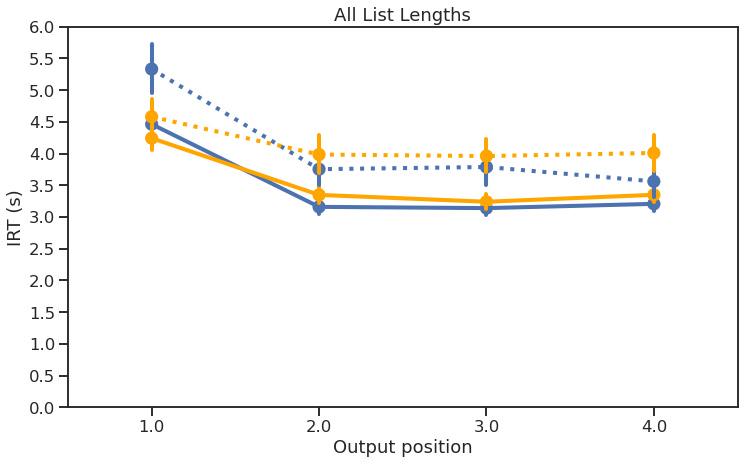

In [20]:
IRT_fig = plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data = win_sub_IRT.query('how == "fwd"'), x='outpos', y='IRT', marker = 'o')
ax2 = sns.pointplot(data = win_sub_IRT.query('how == "bwd"'), x='outpos', y='IRT', marker = 'o', color = 'orange')
ax3 = sns.pointplot(data = win_sub_IRT_wrote.query('how == "fwd"'), x='outpos', y='IRT_wrote_subs', marker = 'o', linestyles = ':')
ax4 = sns.pointplot(data = win_sub_IRT_wrote.query('how == "bwd"'), x='outpos', y='IRT_wrote_subs', marker = 'o', color = 'orange', linestyles = ':')
plt.xlabel('Output position')
plt.ylabel('IRT (s)')
ax2.set_yticks([0.00, 0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 4.50, 5.00, 5.50, 6.00])
plt.title('All List Lengths')

## List Length Effects

### Recall Performance

In [21]:
ros6fwddiff = rosdiff(subs, 6, how = 'fwd')
ros7fwddiff = rosdiff(subs, 7, how = 'fwd')
ros8fwddiff = rosdiff(subs, 8, how = 'fwd')
ros9fwddiff = rosdiff(subs, 9, how = 'fwd')
ros10fwddiff = rosdiff(subs, 10, how = 'fwd')
ros11fwddiff = rosdiff(subs, 11, how = 'fwd')
ros12fwddiff = rosdiff(subs, 12, how = 'fwd')

ros6bwddiff = rosdiff(subs, 6, how = 'bwd')
ros7bwddiff = rosdiff(subs, 7, how = 'bwd')
ros8bwddiff = rosdiff(subs, 8, how = 'bwd')
ros9bwddiff = rosdiff(subs, 9, how = 'bwd')
ros10bwddiff = rosdiff(subs, 10, how = 'bwd')
ros11bwddiff = rosdiff(subs, 11, how = 'bwd')
ros12bwddiff = rosdiff(subs, 12, how = 'bwd')

ros6fwddiff_wrote = rosdiff(wrote_subs, 6, how = 'fwd')
ros7fwddiff_wrote = rosdiff(wrote_subs, 7, how = 'fwd')
ros8fwddiff_wrote = rosdiff(wrote_subs, 8, how = 'fwd')
ros9fwddiff_wrote = rosdiff(wrote_subs, 9, how = 'fwd')
ros10fwddiff_wrote = rosdiff(wrote_subs, 10, how = 'fwd')
ros11fwddiff_wrote = rosdiff(wrote_subs, 11, how = 'fwd')
ros12fwddiff_wrote = rosdiff(wrote_subs, 12, how = 'fwd')

ros6bwddiff_wrote = rosdiff(wrote_subs, 6, how = 'bwd')
ros7bwddiff_wrote = rosdiff(wrote_subs, 7, how = 'bwd')
ros8bwddiff_wrote = rosdiff(wrote_subs, 8, how = 'bwd')
ros9bwddiff_wrote = rosdiff(wrote_subs, 9, how = 'bwd')
ros10bwddiff_wrote = rosdiff(wrote_subs, 10, how = 'bwd')
ros11bwddiff_wrote = rosdiff(wrote_subs, 11, how = 'bwd')
ros12bwddiff_wrote = rosdiff(wrote_subs, 12, how = 'bwd')

In [22]:
rosfwd_diff = pd.concat([ros6fwddiff, ros7fwddiff, ros8fwddiff, ros9fwddiff, ros10fwddiff, ros11fwddiff, ros12fwddiff])
rosbwd_diff = pd.concat([ros6bwddiff, ros7bwddiff, ros8bwddiff, ros9bwddiff, ros10bwddiff, ros11bwddiff, ros12bwddiff])

rosfwd_diff_wrote = pd.concat([ros6fwddiff_wrote, ros7fwddiff_wrote, ros8fwddiff_wrote, ros9fwddiff_wrote, ros10fwddiff_wrote, ros11fwddiff_wrote, ros12fwddiff_wrote])
rosbwd_diff_wrote = pd.concat([ros6bwddiff_wrote, ros7bwddiff_wrote, ros8bwddiff_wrote, ros9bwddiff_wrote, ros10bwddiff_wrote, ros11bwddiff_wrote, ros12bwddiff_wrote])

In [23]:
ros_total = pd.concat([rosfwd_diff, rosbwd_diff])

ros_total['condition'] = '0'
for sub in ros_total.subject.unique():
    if sub in ros6fwddiff.subject.unique():
        ros_total.condition.loc[ros_total.subject == sub] = '1'
    elif sub in ros7fwddiff.subject.unique():
        ros_total.condition.loc[ros_total.subject == sub] = '2'
    elif sub in ros8fwddiff.subject.unique():
        ros_total.condition.loc[ros_total.subject == sub] = '3'

remove_na_ros = []
for number, subject in enumerate(ros_total.subject.loc[ros_total.probability.isna() == True]):
    remove_na_crp.append(subject)
ros_total = ros_total.query('subject not in @remove_na_ros')

In [24]:
ros_total_wrote = pd.concat([rosfwd_diff_wrote, rosbwd_diff_wrote])

remove_na_ros = []
for number, subject in enumerate(ros_total_wrote.subject.loc[ros_total_wrote.probability.isna() == True]):
    remove_na_crp.append(subject)
ros_total_wrote = ros_total_wrote.query('subject not in @remove_na_ros')

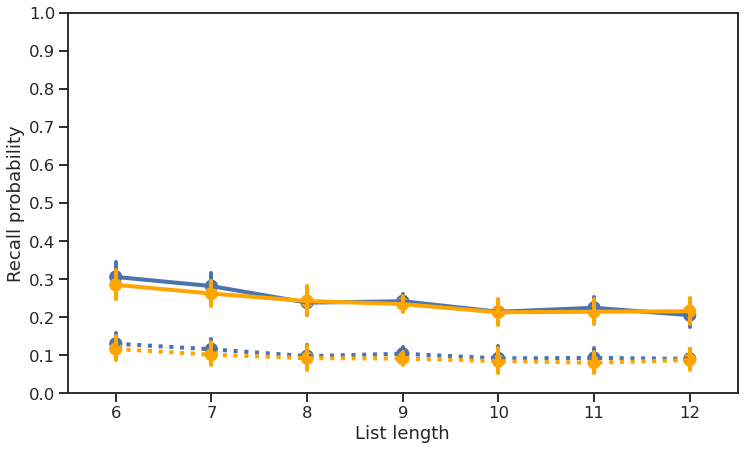

In [25]:
rosdiff_fig= plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=ros_total_wrote.query('how == "fwd"'), x='list_length', y='probability', marker = 'o', linestyles = ':')
ax2 = sns.pointplot(data=ros_total_wrote.query('how == "bwd"'), x='list_length', y='probability', marker = 'o', color = 'orange', linestyles = ':')
ax3 = sns.pointplot(data=ros_total.query('how == "fwd"'), x='list_length', y='probability', marker = 'o')
ax4 = sns.pointplot(data=ros_total.query('how == "bwd"'), x='list_length', y='probability', marker = 'o', color = 'orange')
plt.xlabel('List length')
plt.ylabel('Recall probability')
ax3.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# rosdiff_fig.savefig("./../graphs/rosdiff.pdf", bbox_inches = 'tight',pad_inches = 0.2)

### Recall Initiation

In [27]:
pfr6fwd = pfr(subs, 6, how = 'fwd').query('x_values == 1')
pfr7fwd = pfr(subs, 7, how = 'fwd').query('x_values == 1')
pfr8fwd = pfr(subs, 8, how = 'fwd').query('x_values == 1')
pfr9fwd = pfr(subs, 9, how = 'fwd').query('x_values == 1')
pfr10fwd = pfr(subs, 10, how = 'fwd').query('x_values == 1')
pfr11fwd = pfr(subs, 11, how = 'fwd').query('x_values == 1')
pfr12fwd = pfr(subs, 12, how = 'fwd').query('x_values == 1')
pfr6bwd = pfr(subs, 6, how = 'bwd').query('x_values == 6')
pfr7bwd = pfr(subs, 7, how = 'bwd').query('x_values == 7')
pfr8bwd = pfr(subs, 8, how = 'bwd').query('x_values == 8')
pfr9bwd = pfr(subs, 9, how = 'bwd').query('x_values == 9')
pfr10bwd = pfr(subs, 10, how = 'bwd').query('x_values == 10')
pfr11bwd = pfr(subs, 11, how = 'bwd').query('x_values == 11')
pfr12bwd = pfr(subs, 12, how = 'bwd').query('x_values == 12')

pfr6fwd_wrote = pfr(wrote_subs, 6, how = 'fwd').query('x_values == 1')
pfr7fwd_wrote = pfr(wrote_subs, 7, how = 'fwd').query('x_values == 1')
pfr8fwd_wrote = pfr(wrote_subs, 8, how = 'fwd').query('x_values == 1')
pfr9fwd_wrote = pfr(wrote_subs, 9, how = 'fwd').query('x_values == 1')
pfr10fwd_wrote = pfr(wrote_subs, 10, how = 'fwd').query('x_values == 1')
pfr11fwd_wrote = pfr(wrote_subs, 11, how = 'fwd').query('x_values == 1')
pfr12fwd_wrote = pfr(wrote_subs, 12, how = 'fwd').query('x_values == 1')
pfr6bwd_wrote = pfr(wrote_subs, 6, how = 'bwd').query('x_values == 6')
pfr7bwd_wrote = pfr(wrote_subs, 7, how = 'bwd').query('x_values == 7')
pfr8bwd_wrote = pfr(wrote_subs, 8, how = 'bwd').query('x_values == 8')
pfr9bwd_wrote = pfr(wrote_subs, 9, how = 'bwd').query('x_values == 9')
pfr10bwd_wrote = pfr(wrote_subs, 10, how = 'bwd').query('x_values == 10')
pfr11bwd_wrote = pfr(wrote_subs, 11, how = 'bwd').query('x_values == 11')
pfr12bwd_wrote = pfr(wrote_subs, 12, how = 'bwd').query('x_values == 12')

In [28]:
pfr_fwd = pd.concat([pfr6fwd, pfr7fwd, pfr8fwd, pfr9fwd, pfr10fwd, pfr11fwd, pfr12fwd])
pfr_bwd = pd.concat([pfr6bwd, pfr7bwd, pfr8bwd, pfr9bwd, pfr10bwd, pfr11bwd, pfr12bwd])

pfr_fwd_wrote = pd.concat([pfr6fwd_wrote, pfr7fwd_wrote, pfr8fwd_wrote, pfr9fwd_wrote, pfr10fwd_wrote, pfr11fwd_wrote, pfr12fwd_wrote])
pfr_bwd_wrote = pd.concat([pfr6bwd_wrote, pfr7bwd_wrote, pfr8bwd_wrote, pfr9bwd_wrote, pfr10bwd_wrote, pfr11bwd_wrote, pfr12bwd_wrote])

In [29]:
pfr_total = pd.concat([pfr_fwd, pfr_bwd])
pfr_total['condition'] = '0'

for sub in pfr_total.subject.unique():
    if sub in pfr6fwd.subject.unique():
        pfr_total.condition.loc[pfr_total.subject == sub] = '1'
    elif sub in pfr7fwd.subject.unique():
        pfr_total.condition.loc[pfr_total.subject == sub] = '2'
    elif sub in pfr8fwd.subject.unique():
        pfr_total.condition.loc[pfr_total.subject == sub] = '3'
remove_na_pfr = []
for number, subject in enumerate(pfr_total.subject.loc[pfr_total.probability.isna() == True]):
    remove_na_pfr.append(subject)
pfr_total = pfr_total.query('subject not in @remove_na_pfr')

In [30]:
pfr_total_wrote = pd.concat([pfr_fwd_wrote, pfr_bwd_wrote])

remove_na_pfr = []
for number, subject in enumerate(pfr_total_wrote.subject.loc[pfr_total_wrote.probability.isna() == True]):
    remove_na_pfr.append(subject)
pfr_total_wrote = pfr_total_wrote.query('subject not in @remove_na_pfr')

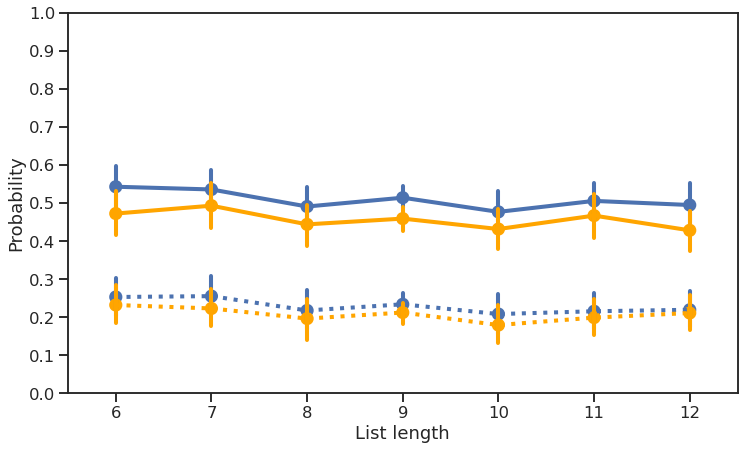

In [31]:
pfr_diff_fig= plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=pfr_total.query('how == "fwd"'), x='list_length', y='probability', marker = 'o')
ax2 = sns.pointplot(data=pfr_total.query('how == "bwd"'), x='list_length', y='probability', marker = 'o', color = 'orange')
ax3 = sns.pointplot(data=pfr_total_wrote.query('how == "fwd"'), x='list_length', y='probability', marker = 'o', linestyles = ':')
ax4 = sns.pointplot(data=pfr_total_wrote.query('how == "bwd"'), x='list_length', y='probability', marker = 'o', color = 'orange', linestyles = ':')
plt.xlabel('List length')
plt.ylabel('Probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# pfr_diff_fig.savefig("./../graphs/pfr_diff.pdf", bbox_inches = 'tight',pad_inches = 0.2)

### Recall Transitions

In [32]:
crp6fwd = lagCRP_curve(subs, 6, how = 'fwd').query('x_values == -1')
crp7fwd = lagCRP_curve(subs, 7, how = 'fwd').query('x_values == -1')
crp8fwd = lagCRP_curve(subs, 8, how = 'fwd').query('x_values == -1')
crp9fwd = lagCRP_curve(subs, 9, how = 'fwd').query('x_values == -1')
crp10fwd = lagCRP_curve(subs, 10, how = 'fwd').query('x_values == -1')
crp11fwd = lagCRP_curve(subs, 11, how = 'fwd').query('x_values == -1')
crp12fwd = lagCRP_curve(subs, 12, how = 'fwd').query('x_values == -1')
crp6bwd = lagCRP_curve(subs, 6, how = 'bwd').query('x_values == -1')
crp7bwd = lagCRP_curve(subs, 7, how = 'bwd').query('x_values == -1')
crp8bwd = lagCRP_curve(subs, 8, how = 'bwd').query('x_values == -1')
crp9bwd = lagCRP_curve(subs, 9, how = 'bwd').query('x_values == -1')
crp10bwd = lagCRP_curve(subs, 10, how = 'bwd').query('x_values == -1')
crp11bwd = lagCRP_curve(subs, 11, how = 'bwd').query('x_values == -1')
crp12bwd = lagCRP_curve(subs, 12, how = 'bwd').query('x_values == -1')

crp6fwd_wrote= lagCRP_curve(wrote_subs, 6, how = 'fwd').query('x_values == -1')
crp7fwd_wrote= lagCRP_curve(wrote_subs, 7, how = 'fwd').query('x_values == -1')
crp8fwd_wrote= lagCRP_curve(wrote_subs, 8, how = 'fwd').query('x_values == -1')
crp9fwd_wrote= lagCRP_curve(wrote_subs, 9, how = 'fwd').query('x_values == -1')
crp10fwd_wrote= lagCRP_curve(wrote_subs, 10, how = 'fwd').query('x_values == -1')
crp11fwd_wrote= lagCRP_curve(wrote_subs, 11, how = 'fwd').query('x_values == -1')
crp12fwd_wrote= lagCRP_curve(wrote_subs, 12, how = 'fwd').query('x_values == -1')
crp6bwd_wrote= lagCRP_curve(wrote_subs, 6, how = 'bwd').query('x_values == -1')
crp7bwd_wrote= lagCRP_curve(wrote_subs, 7, how = 'bwd').query('x_values == -1')
crp8bwd_wrote= lagCRP_curve(wrote_subs, 8, how = 'bwd').query('x_values == -1')
crp9bwd_wrote= lagCRP_curve(wrote_subs, 9, how = 'bwd').query('x_values == -1')
crp10bwd_wrote= lagCRP_curve(wrote_subs, 10, how = 'bwd').query('x_values == -1')
crp11bwd_wrote= lagCRP_curve(wrote_subs, 11, how = 'bwd').query('x_values == -1')
crp12bwd_wrote= lagCRP_curve(wrote_subs, 12, how = 'bwd').query('x_values == -1')


In [33]:
crpfwd = pd.concat([crp6fwd, crp7fwd, crp8fwd, crp9fwd, crp10fwd, crp11fwd, crp12fwd])
crpbwd = pd.concat([crp6bwd, crp7bwd, crp8bwd, crp9bwd, crp10bwd, crp11bwd, crp12bwd])

crpfwd_wrote = pd.concat([crp6fwd_wrote, crp7fwd_wrote, crp8fwd_wrote, crp9fwd_wrote, crp10fwd_wrote, crp11fwd_wrote, crp12fwd_wrote])
crpbwd_wrote = pd.concat([crp6bwd_wrote, crp7bwd_wrote, crp8bwd_wrote, crp9bwd_wrote, crp10bwd_wrote, crp11bwd_wrote, crp12bwd_wrote])


In [34]:
crp_total = pd.concat([crpfwd, crpbwd])

crp_total['condition'] = '0'
for sub in crp_total.subject.unique():
    if sub in crp6fwd.subject.unique():
        crp_total.condition.loc[crp_total.subject == sub] = '1'
    elif sub in crp7fwd.subject.unique():
        crp_total.condition.loc[crp_total.subject == sub] = '2'
    elif sub in crp8fwd.subject.unique():
        crp_total.condition.loc[crp_total.subject == sub] = '3'

remove_na_crp = []
for number, subject in enumerate(crp_total.subject.loc[crp_total.probability.isna() == True]):
    remove_na_crp.append(subject)
    
crp_total = crp_total.query('subject not in @remove_na_crp')

In [35]:
crp_total_wrote = pd.concat([crpfwd_wrote, crpbwd_wrote])

remove_na_crp = []
for number, subject in enumerate(crp_total_wrote.subject.loc[crp_total_wrote.probability.isna() == True]):
    remove_na_crp.append(subject)
crp_total_wrote = crp_total_wrote.query('subject not in @remove_na_crp')

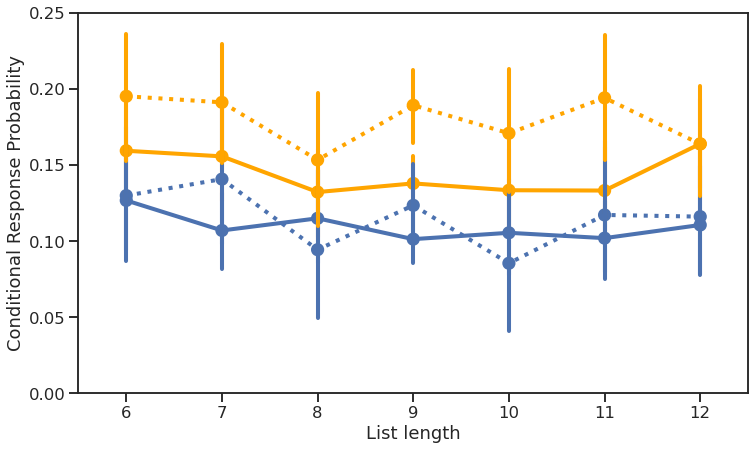

In [36]:
crpdiff_fig= plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=crp_total.query('how == "fwd"'), x='list_length', y='probability', marker = 'o')
ax2 = sns.pointplot(data=crp_total.query('how == "bwd"'), x='list_length', y='probability', marker = 'o', color = 'orange')
ax3 = sns.pointplot(data=crp_total_wrote.query('how == "fwd"'), x='list_length', y='probability', marker = 'o', linestyles = ':')
ax4 = sns.pointplot(data=crp_total_wrote.query('how == "bwd"'), x='list_length', y='probability', marker = 'o', color = 'orange', linestyles = ':')
plt.xlabel('List length')
plt.ylabel('Conditional Response Probability')
ax3.set_yticks([0.00, 0.05, 0.10, 0.15, 0.20, 0.25])
# crpdiff_fig.savefig("./../graphs/crpdiff.pdf", bbox_inches = 'tight',pad_inches = 0.2)